In [11]:
import matplotlib.pyplot as plt

from qwfs.qwfs_result import QWFSResult
%autoreload 2
%matplotlib ipympl
import os 
import numpy as np 
np.random.seed(42)
from qwfs.qwfs_simulation import QWFSSimulation, tnow
DATA_DIR = os.path.join(os.path.abspath(os.path.curdir), 'data')

### generate results

In [127]:
N_modes = 512 
N_tries = 1
configs = ['SLM1-only-TT'] # , 'SLM1-after']
T_methods = ['gaus_iid']
algos = ['autograd-lbfgs']
# cost_function = 'energy'
cost_function = 'contrast'
# saveto_path = None 
saveto_path = rf'{DATA_DIR}\contrast\{tnow()}_cost_{cost_function}_{N_tries}_tries_Nmodes_{N_modes}.npz'

s = QWFSSimulation(N=N_modes)
s.cost_function = cost_function
res = s.statistics(algos=algos, configs=configs, T_methods=T_methods, N_tries=N_tries, saveto_path=saveto_path, save_Ts=False, save_phases=False)

try_no=0
try_no=1
try_no=2
try_no=3
try_no=4
try_no=5
try_no=6
try_no=7
try_no=8
try_no=9
try_no=10
try_no=11
try_no=12
try_no=13
try_no=14
try_no=15
try_no=16
try_no=17
try_no=18
try_no=19
try_no=20
try_no=21
try_no=22
try_no=23
try_no=24
try_no=25
try_no=26
try_no=27
try_no=28
try_no=29


### load result

In [90]:
# res.show_scatterplots()
import glob
from qwfs.qwfs_result import QWFSResult
path = glob.glob(rf'{DATA_DIR}\contrast\*cost_energy*')[-1]  # 256, 700
# path = glob.glob(rf'{DATA_DIR}\contrast\*cost_contrast*')[0]
res = QWFSResult(path=path)

### View statistics

In [91]:
i = 0 # Gaussian IID
# i = 1 # Gaussian IID
optimized = res.results[i, :, :, 0].mean(axis=1)
optimized_std = res.results[i, :, :, 0].std(axis=1)
tot_power = res.tot_power_results[i, :, :, 0].mean(axis=1)
tot_power_std = res.tot_power_results[i, :, :, 0].std(axis=1)
background = tot_power - optimized

print('cost_function:', res.cost_function)
print('configs:   ', res.configs)
print(f'optimized: {optimized}+-{optimized_std}')
print(f'tot_power: {tot_power}+-{tot_power_std}')
print(f'background:', tot_power - optimized)
print(f'contrast:', optimized / background)
print(f'energy_from_tot:', optimized / tot_power)
print('pi/4 =', np.pi/4)

cost_function: energy
configs:    ['SLM1-only-TT']
optimized: [0.916317]+-[0.]
tot_power: [2.67523455]+-[0.]
background: [1.75891754]
contrast: [0.52095506]
energy_from_tot: [0.34251838]
pi/4 = 0.7853981633974483


### Rerun and view distribution
right after generating results, just the last thing that ran 

In [ ]:
rand_phases = np.exp(1j*2*np.pi*np.random.rand(s.N))
v_out = s.T @ s.T.transpose() @ (s.slm_phases * s.v_in)
# v_out = s.T @ s.T.transpose() @ (rand_phases * s.v_in)
I_out = (np.abs(v_out) ** 2)
fig, ax = plt.subplots()
ax.plot(I_out)
ax.set_xlabel('mode no.')
ax.set_ylabel('I')
print(I_out[s.DEFAULT_OUT_MODE])
print(I_out.sum())
print('----------')
print('pi/4=', np.pi/4)
print('1+pi/2=', 1+np.pi/2)

In "crystal plane" 

0.004538546878355636
1.8195578558270038
----------
pi/4= 0.7853981633974483
1+pi/2= 2.5707963267948966


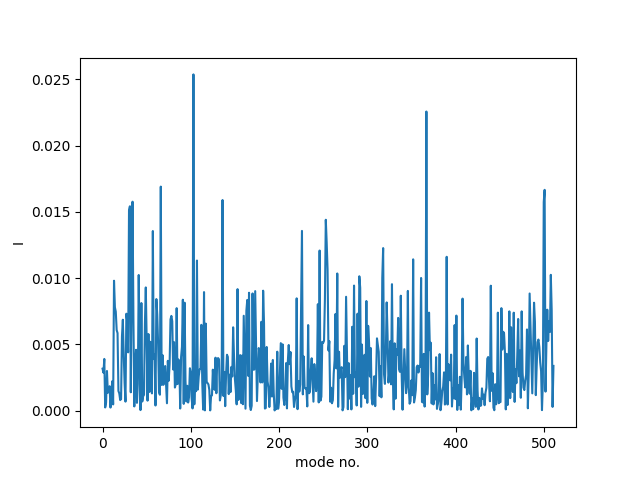

In [89]:
rand_phases = np.exp(1j*2*np.pi*np.random.rand(s.N))
# v_out = s.T.transpose() @ (rand_phases * s.v_in)
v_out = s.T.transpose() @ (s.slm_phases * s.v_in)
I_out = (np.abs(v_out) ** 2)
fig, ax = plt.subplots()
ax.plot(I_out)
ax.set_xlabel('mode no.')
ax.set_ylabel('I')
print(I_out[s.DEFAULT_OUT_MODE])
print(I_out.sum())
print('----------')
print('pi/4=', np.pi/4)
print('1+pi/2=', 1+np.pi/2)

-----------------------------------
## incomplete control

In [93]:
"""
double_pass_wfs_figures.py
==========================

Numerical verification of
    Shekel & Bromberg, "Enhanced Background Intensity …"

*   Fig. 1 : full control  (f = 1)  --->  I_alpha → π/4,  P_bg → 1+π/4
*   Fig. 2 : incomplete control      --->  linear scaling with f

-----------------------------------------------------------
Python ≥ 3.8, NumPy, Matplotlib.
Execution time: a few minutes on a laptop for the default
1000 realisations per data point.  Increase 'n_real' for
smaller error bars.
-----------------------------------------------------------
"""

import numpy as np
import matplotlib.pyplot as plt

# ---------- simulation core -----------------------------------------------
def one_realisation_full(N, alpha=0):
    """Single Monte-Carlo realisation, full phase control (f = 1)."""
    # single-pass transmission matrix T ~ CN(0,1/N)
    T = (np.random.randn(N, N) + 1j * np.random.randn(N, N)) / np.sqrt(2 * N)
    R = T @ T.T                                  # double-pass matrix TTᵀ
    phases = np.exp(-1j * np.angle(R[alpha]))    # optimal SLM phases
    E_in   = phases / np.sqrt(N)                 # unit total power
    E_out  = R @ E_in
    I_alpha = np.abs(E_out[alpha])**2
    P_bg    = np.sum(np.abs(E_out)**2) - I_alpha
    return I_alpha, P_bg

def one_realisation_incomplete(N, f, alpha=0):
    """Single Monte-Carlo realisation for degree of control f = M/N."""
    M = int(np.round(f * N))              # number of independent SLM pixels
    m = N // M                            # modes per macro-pixel (assume N divisible)
    T = (np.random.randn(N, N) + 1j * np.random.randn(N, N)) / np.sqrt(2 * N)
    R = T @ T.T
    # coarse-grained optimal phase: one phase per macro-pixel i
    phases = np.empty(N, dtype=np.complex128)
    for i in range(M):
        ind = slice(i * m, (i + 1) * m)           # modes controlled by pixel i
        x_i = np.sum(R[alpha, ind])               # summed complex field
        phi_i = -np.angle(x_i)
        phases[ind] = np.exp(1j * phi_i)
    E_in  = phases / np.sqrt(N)                   # still unit total power
    E_out = R @ E_in
    I_alpha = np.abs(E_out[alpha])**2
    P_bg    = np.sum(np.abs(E_out)**2) - I_alpha
    return I_alpha, P_bg

In [122]:
# ---------- figure 1 : full control vs N -----------------------------------
Ns     = np.array([64, 128, 256, 512, 1024])
n_real = 100                                   # repetitions per N
I_mean, P_mean = [], []
I_std, P_std = [], []

for N in Ns:
    I_list, P_list = [], []
    for _ in range(n_real):
        I, P = one_realisation_full(N)
        I_list.append(I)
        P_list.append(P)
    I_mean.append(np.mean(I_list))
    I_std.append(np.std(I_list) / np.sqrt(n_real)) 
    P_mean.append(np.mean(P_list))
    P_std.append(np.std(P_list) / np.sqrt(n_real)) 
    print(f"N={N:4d}: <I_alpha>={np.mean(I_list):.4f}, <P_bg>={np.mean(P_list):.4f}")


N=  64: <I_alpha>=0.8130, <P_bg>=1.7917
N= 128: <I_alpha>=0.7989, <P_bg>=1.7761
N= 256: <I_alpha>=0.7890, <P_bg>=1.7934
N= 512: <I_alpha>=0.7864, <P_bg>=1.7843
N=1024: <I_alpha>=0.7874, <P_bg>=1.7885


Saved fig_full_control.pdf


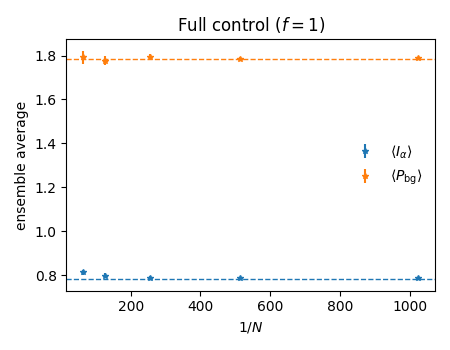

In [123]:
fig1, ax1 = plt.subplots(figsize=(4.5, 3.5))

ax1.errorbar(Ns, I_mean, yerr=I_std, label=r"$\langle I_\alpha\rangle$", linestyle='none', markersize=4, marker='*')
ax1.errorbar(Ns, P_mean, yerr=P_std, label=r"$\langle P_{\mathrm{bg}}\rangle$", linestyle='none', markersize=4, marker='*')
ax1.axhline(np.pi/4,        ls="--", lw=1, c="C0")
ax1.axhline(1+np.pi/4,      ls="--", lw=1, c="C1")
ax1.set_xlabel(r"$1/N$")
ax1.set_ylabel("ensemble average")
ax1.set_title("Full control ($f=1$)")
ax1.legend(frameon=False)
fig1.tight_layout()
fig1.savefig(r"C:\temp\fig_full_control.pdf")
print("Saved fig_full_control.pdf")
fig.show()

In [124]:
# ---------- figure 2 : incomplete control vs f ------------------------------
N_fixed = 512
fs = 1 / np.array([1, 2, 4, 8, 16])
I_f, P_f = [], []
I_std, P_std = [], []

for f in fs:
    I_list, P_list = [], []
    for _ in range(n_real):
        I, P = one_realisation_incomplete(N_fixed, f)
        I_list.append(I)
        P_list.append(P)
    I_f.append(np.mean(I_list))
    I_std.append(np.std(I_list) / np.sqrt(n_real))
    P_f.append(np.mean(P_list))
    P_std.append(np.std(P_list) / np.sqrt(n_real))
    print(f"f={f:5.3f}: <I_alpha>={np.mean(I_list):.4f}, <P_bg>={np.mean(P_list):.4f}")

f=1.000: <I_alpha>=0.7830, <P_bg>=1.7651
f=0.500: <I_alpha>=0.3931, <P_bg>=1.3985
f=0.250: <I_alpha>=0.2012, <P_bg>=1.2085
f=0.125: <I_alpha>=0.1005, <P_bg>=1.0949
f=0.062: <I_alpha>=0.0509, <P_bg>=1.0468


Saved c:\temp\fig_incomplete_control.pdf


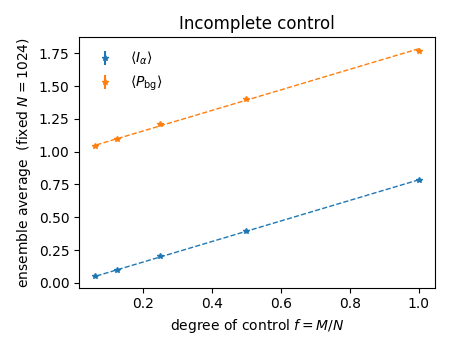

In [125]:
fig2, ax2 = plt.subplots(figsize=(4.5, 3.5))
ax2.errorbar(fs, I_f, I_std, label=r"$\langle I_\alpha\rangle$", linestyle='none', markersize=4, marker='*')
ax2.errorbar(fs, P_f, P_std, label=r"$\langle P_{\mathrm{bg}}\rangle$", linestyle='none', markersize=4, marker='*')
ax2.plot(fs, (np.pi/4)*fs,       ls="--", lw=1, c="C0")             # theory I_alpha
ax2.plot(fs, 1+(np.pi/4)*fs,     ls="--", lw=1, c="C1")             # theory P_bg
ax2.set_xlabel(r"degree of control $f=M/N$")
ax2.set_ylabel("ensemble average  (fixed $N=1024$)")
ax2.set_title("Incomplete control")
ax2.legend(frameon=False)
fig2.tight_layout()
fig2.savefig(r"c:\temp\fig_incomplete_control.pdf")
print(r"Saved c:\temp\fig_incomplete_control.pdf")

plt.show()